In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv('../data/boston_housing.csv')

In [11]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [12]:
def preprocess_data(df, handle_outliers=True, encode_rad=True, standardize=True):
    df_processed = df.copy()
    
    # Handle outliers if specified
    if handle_outliers:
        for col in ['crim', 'zn', 'b', 'lstat']:
            df_processed = remove_outliers(df_processed, col)
    
    # Encode 'rad' if specified
    if encode_rad:
        df_processed = pd.get_dummies(df_processed, columns=['rad'], prefix='rad', drop_first=True)
    
    # Separate features and target
    X = df_processed.drop('medv', axis=1)
    y = df_processed['medv']
    
    # Standardize numerical features if specified
    numerical_cols = ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'b', 'lstat']
    if standardize:
        scaler = StandardScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    return X, y

In [16]:
# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"\n{model_name} Performance:")
    print(f"Training MSE: {mse_train:.2f}, R²: {r2_train:.2f}")
    print(f"Testing MSE: {mse_test:.2f}, R²: {r2_test:.2f}")
    
    # Residuals
    residuals = y_test - y_pred_test
    
    # Plot residuals
    plt.figure(figsize=(12, 4))
    
    # Residuals vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred_test, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f'{model_name}: Residuals vs Predicted')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    # Residuals Histogram
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title(f'{model_name}: Residuals Distribution')
    plt.xlabel('Residuals')

    plt.tight_layout()
    plt.show()
    
    return mse_test, r2_test, residuals

In [17]:
# 1. Define Feature Sets
correlation = df.corr()['medv'].abs().sort_values(ascending=False)
high_corr_features = correlation[correlation > 0.5].index.drop('medv').tolist()  # Strong predictors
all_features = df.columns.drop('medv').tolist()  # All original features


Running: Linear Regression - All Features, Full Preprocessing

Linear Regression - All Features, Full Preprocessing Performance:
Training MSE: 21.72, R²: 0.75
Testing MSE: 24.36, R²: 0.67


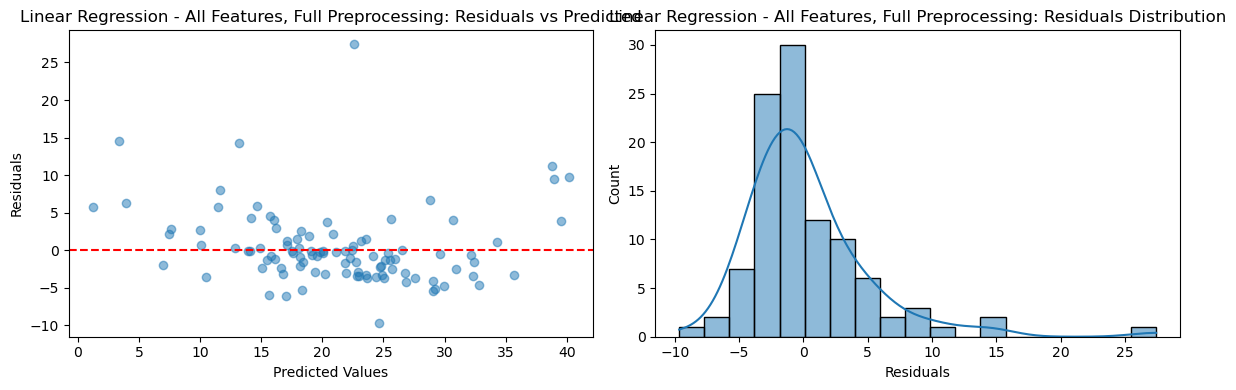


Running: Linear Regression - High Corr Features, Full Preprocessing

Linear Regression - High Corr Features, Full Preprocessing Performance:
Training MSE: 26.77, R²: 0.69
Testing MSE: 26.30, R²: 0.64


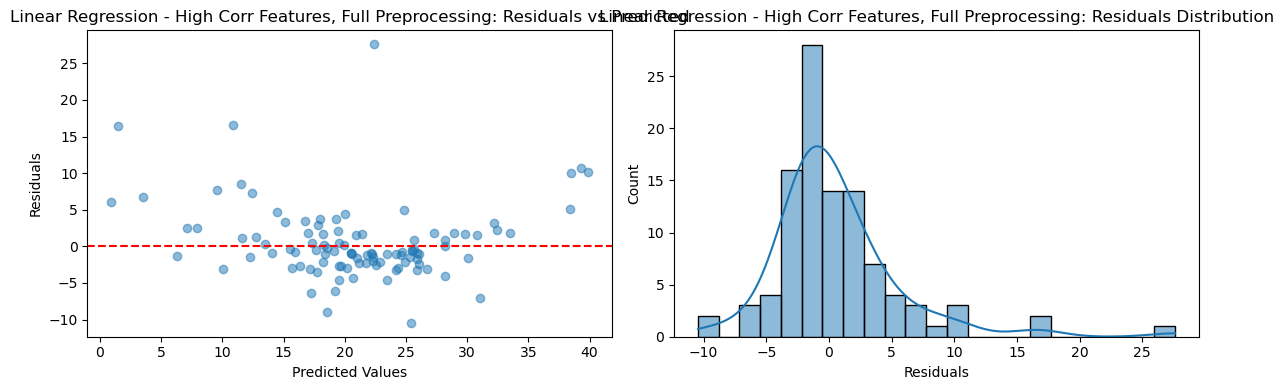


Running: Linear Regression - All Features, No Outlier Handling

Linear Regression - All Features, No Outlier Handling Performance:
Training MSE: 20.60, R²: 0.76
Testing MSE: 24.82, R²: 0.66


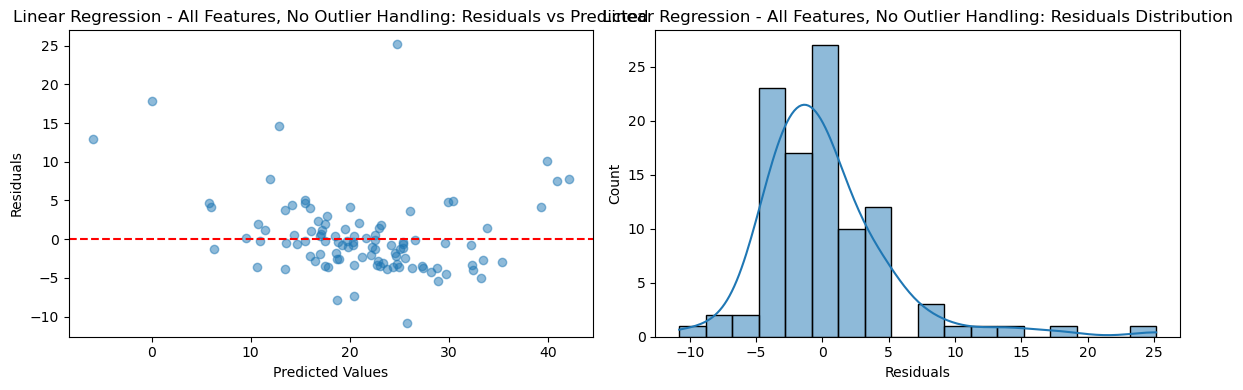


Running: Ridge - All Features, Full Preprocessing

Ridge - All Features, Full Preprocessing Performance:
Training MSE: 21.78, R²: 0.75
Testing MSE: 24.64, R²: 0.66


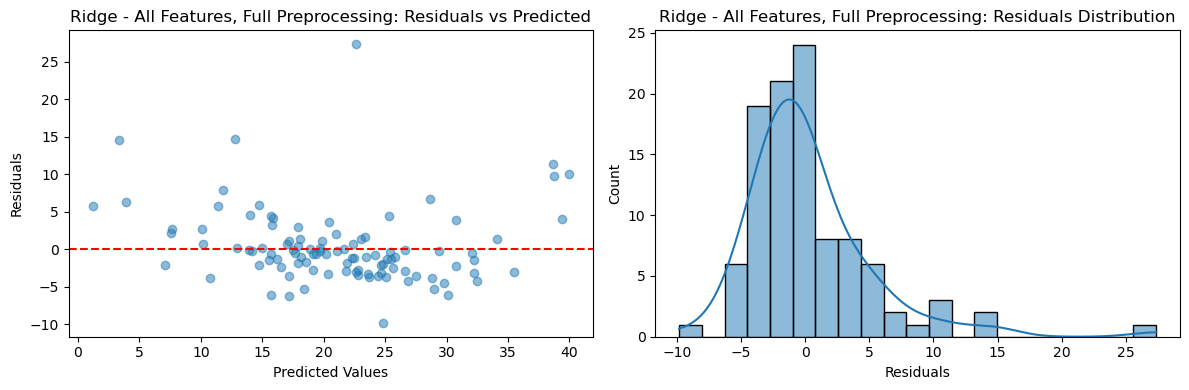

In [18]:
# 2. Experiment with Different Preprocessing and Feature Sets
experiments = [
    {"name": "Linear Regression - All Features, Full Preprocessing", 
     "model": LinearRegression(), 
     "features": None,  # Use all features after encoding
     "handle_outliers": True, "encode_rad": True, "standardize": True},
    {"name": "Linear Regression - High Corr Features, Full Preprocessing", 
     "model": LinearRegression(), 
     "features": high_corr_features, 
     "handle_outliers": True, "encode_rad": True, "standardize": True},
    {"name": "Linear Regression - All Features, No Outlier Handling", 
     "model": LinearRegression(), 
     "features": None, 
     "handle_outliers": False, "encode_rad": True, "standardize": True},
    {"name": "Ridge - All Features, Full Preprocessing", 
     "model": Ridge(alpha=1.0), 
     "features": None, 
     "handle_outliers": True, "encode_rad": True, "standardize": True}
]

# Results storage
results = []

# Run experiments
for exp in experiments:
    print(f"\nRunning: {exp['name']}")
    
    # Preprocess data
    X, y = preprocess_data(df, exp["handle_outliers"], exp["encode_rad"], exp["standardize"])
    
    # Select features if specified
    if exp["features"]:
        X = X[exp["features"]]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Evaluate model
    mse, r2, residuals = evaluate_model(exp["model"], X_train, X_test, y_train, y_test, exp["name"])
    results.append({"name": exp["name"], "MSE": mse, "R²": r2})


Model Comparison:
                                                name        MSE        R²
0  Linear Regression - All Features, Full Preproc...  24.355476  0.667882
1  Linear Regression - High Corr Features, Full P...  26.304604  0.641303
2  Linear Regression - All Features, No Outlier H...  24.818443  0.661569
3           Ridge - All Features, Full Preprocessing  24.642844  0.663963


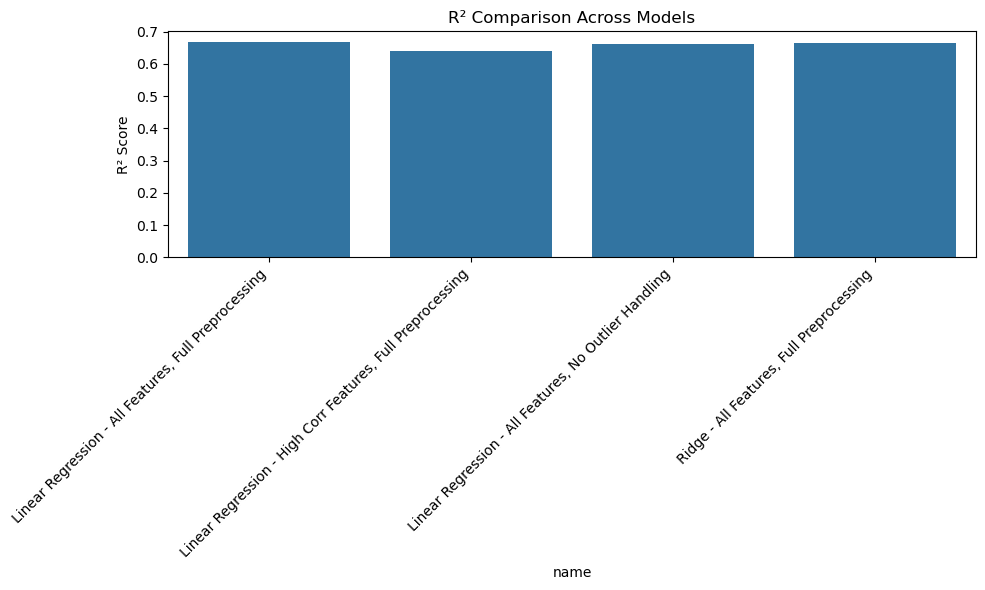

In [19]:
# 3. Compare Results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Bar plot for comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="name", y="R²", data=results_df)
plt.xticks(rotation=45, ha='right')
plt.title('R² Comparison Across Models')
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()